In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import seaborn as sns
import matplotlib.pyplot as plt

# Профилирование клиентов сети продуктовых магазинов

*Цель*: разделить клиентов на группы(кластеры) на основе их покупательского поведения для разработки персонализированных маркетинговых стратегий

*Данные*: У нас есть датасет с информацией о покупках клиентов, включающих следующие признаки
- Анонимизированные персональные характеристики клиентов магазина
- Информация о количестве покупок клиентов по разным категориям товаров
- Информация о промо-акциях
- Место покупки: онлайн, оффлайн, каталог, количество визитов на сайт магазина


# Загрузка данных

In [12]:
df = pd.read_csv('../Downloads/marketing_campaign.csv', sep = '\t')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

# Предобработка данных

In [13]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [14]:
print(df.isnull().any())

ID                     False
Year_Birth             False
Education              False
Marital_Status         False
Income                  True
Kidhome                False
Teenhome               False
Dt_Customer            False
Recency                False
MntWines               False
MntFruits              False
MntMeatProducts        False
MntFishProducts        False
MntSweetProducts       False
MntGoldProds           False
NumDealsPurchases      False
NumWebPurchases        False
NumCatalogPurchases    False
NumStorePurchases      False
NumWebVisitsMonth      False
AcceptedCmp3           False
AcceptedCmp4           False
AcceptedCmp5           False
AcceptedCmp1           False
AcceptedCmp2           False
Complain               False
Z_CostContact          False
Z_Revenue              False
Response               False
dtype: bool


In [15]:
df = df.dropna()

In [16]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], format="%d-%m-%Y")
dates = []
for i in df["Dt_Customer"]:
    i = i.date()
    dates.append(i)  

print("Дата регистрации самого нового клиента:", max(dates))
print("Дата регистрации самого 'старого' клиентa", min(dates))


Дата регистрации самого нового клиента: 2014-06-29
Дата регистрации самого 'старого' клиентa 2012-07-30


In [17]:
dates = pd.to_datetime(dates)

# Количество дней с момента появления нового клиента
df["Customer_For"] = (dates.max() - dates).days

# Проверим, что столбец «Customer_For» содержит только числовые значения.
df["Customer_For"] = pd.to_numeric(df["Customer_For"], errors="coerce")

In [18]:
df["Age"] = 2014 - df["Year_Birth"]

#Общие расходы по различным категориям
df["Spent"] = df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] + df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]

#Отобразим Marital_Status в пространство с меньшим количеством категорий
df["Living_With"] = df["Marital_Status"].replace({
    "Married": "Partner", 
    "Together": "Partner", 
    "Absurd": "Single", 
    "Widow": "Single", 
    "YOLO": "Single", 
    "Divorced": "Single",
    "Alone": "Single"
})

#Общее количество детей, проживающих в одном доме
df["Children"] = df["Kidhome"] + df["Teenhome"]

#Общее количество людей, проживающих в одном доме
df["Family_Size"] = df["Living_With"].replace({"Single": 1, "Partner": 2})+ df["Children"]

#Введем признак отображающий является ли клиент родителем
df["Is_Parent"] = np.where(df.Children> 0, 1, 0)

#Разделим Образование на три категории
df["Education"] = df["Education"].replace({
    "Basic": "Undergraduate",
    "2n Cycle": "Undergraduate", 
    "Graduation": "Graduate", 
    "Master": "Postgraduate", 
    "PhD": "Postgraduate"
})

#Для удобства в дальнейшем, переименуем некоторые признаки
df = df.rename(columns = {
    "MntWines": "Wines",
    "MntFruits": "Fruits",
    "MntMeatProducts": "Meat",
    "MntFishProducts": "Fish",
    "MntSweetProducts": "Sweets",
    "MntGoldProds": "Gold"
})

#Удалим избыточные признаки
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth"]
df = df.drop(to_drop, axis=1)

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Income'}>]], dtype=object)

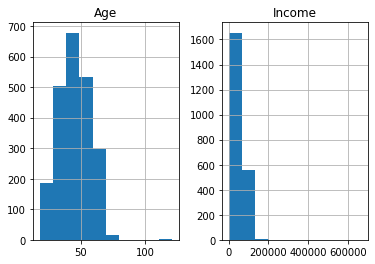

In [19]:
df[['Age', 'Income']].hist()

In [20]:
#Удалим выбросы в признаках возраста и дохода
df = df[(df["Age"] < 90)]
df = df[(df["Income"] < 600000)]

In [21]:
s = (df.dtypes == 'object')
object_cols = list(s[s].index)

print("Категориальные признаки:", object_cols)

Категориальные признаки: ['Education', 'Living_With']


# Перевод категориальных признаков в числовые

Так как любой алгоритм машинного обучения основан на математических операциях, ме не можем использовать категориальные признаки в сыром виде. Поэтому мы  закодируем их тем или иным  методом LabelEncoder, который каждому классу ставит в соответсвие число от 0 до n-1, где n- это количество классов/категорий:
$$ LabelEncoder(category_i) = i $$
$$\ i=1 \dots n $$


In [22]:
LE = LabelEncoder()
for i in object_cols:
    df[i] = df[[i]].apply(LE.fit_transform)

In [23]:
# Нормализируем признаки
ds = df.copy()
cols_del = ['ID', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)

scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
scaled_ds.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.527721,1.018352,1.676245,1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.189011,1.274785,-0.963297,1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.206048,0.334530,0.280110,-0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.060584,-1.289547,-0.920135,-0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.951915,-1.033114,-0.307562,-0.740959,0.069987,0.449070,0.632456


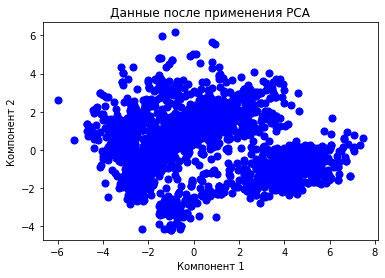

In [24]:
# Визуализация данных клиеннтов с помощью Принципа главных компонент (PCA)
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(scaled_ds)


plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', marker='o', s=50)
plt.title('Данные после применения PCA')
plt.xlabel('Компонент 1')
plt.ylabel('Компонент 2')
plt.show()

## Кластеризация c помощью DBSCAN

Итак, мы проделали те же шаги по преобразованию признаков что и в занятии по k-means, теперь посмотрим как применять новый метод DBSCAN

In [25]:
dbs = DBSCAN(eps=0.5, min_samples=5)
y_pred = dbs.fit_predict(X_pca)

In [26]:
# Посчитаем силуэтный коэффициент и процент шума
clusters = len(np.unique(y_pred))
score = silhouette_score(X_pca, y_pred)
noise_ratio = sum(y_pred == -1)/len(y_pred)
print(f'DBSCAN, Силуэтный коэффициент: {score}')
print(f'Уровень шума: {noise_ratio}')

DBSCAN, Силуэтный коэффициент: 0.09849872133797873
Уровень шума: 0.011301989150090416


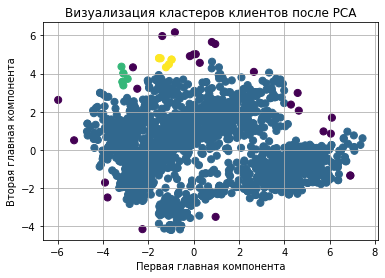

In [27]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_pred, cmap='viridis', s=50)

plt.title('Визуализация кластеров клиентов после PCA')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.grid(True)
plt.show()

In [36]:
from tqdm import tqdm
epsilon_range = np.arange(0.1, 10.0, 0.1)
min_samples_range = range(50, 300, 50)  

results = []

for eps in tqdm(epsilon_range):
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_pca)
        
        # Количество кластеров, не включая шумовой кластер
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        # Считаем силуэтный коэффициент только если количество кластеров больше 1 и меньше than n_samples - 1
        if 1 < n_clusters < len(X_pca) - 1:
            sil_score = silhouette_score(X_pca, labels)
            results.append((eps, min_samples, n_clusters, sil_score))
        else:
            sil_score = -1
            results.append((eps, min_samples, n_clusters, sil_score))

# Отсортируем результаты по силуэтному коэффициенту
results_sorted = sorted(results, key=lambda x: x[3], reverse=True)

for result in results_sorted:
    print(f"eps: {result[0]}, min_samples: {result[1]}, n_clusters: {result[2]}, silhouette_score: {result[3]}")

100%|██████████| 99/99 [00:24<00:00,  4.03it/s]

eps: 1.6, min_samples: 250, n_clusters: 2, silhouette_score: 0.4300465713054733
eps: 1.5000000000000002, min_samples: 200, n_clusters: 2, silhouette_score: 0.4111872773285487
eps: 1.5000000000000002, min_samples: 250, n_clusters: 2, silhouette_score: 0.4022829365079304
eps: 1.4000000000000001, min_samples: 200, n_clusters: 2, silhouette_score: 0.4006427832340042
eps: 0.9, min_samples: 50, n_clusters: 2, silhouette_score: 0.40059779563049275
eps: 1.4000000000000001, min_samples: 250, n_clusters: 2, silhouette_score: 0.38903113084676816
eps: 1.3000000000000003, min_samples: 150, n_clusters: 2, silhouette_score: 0.38765742482211357
eps: 1.3000000000000003, min_samples: 200, n_clusters: 2, silhouette_score: 0.38175561581879136
eps: 0.8, min_samples: 50, n_clusters: 2, silhouette_score: 0.3783947087795825
eps: 1.2000000000000002, min_samples: 150, n_clusters: 2, silhouette_score: 0.37804020588833553
eps: 1.1, min_samples: 100, n_clusters: 2, silhouette_score: 0.37439613324772547
eps: 1.3000

In [37]:
dbs = DBSCAN(eps=1.6, min_samples=250)
y_pred = dbs.fit_predict(X_pca)

In [38]:
df['Clusters'] = y_pred

# Измерение качества кластеров

Силуэтный коэффициент
$$ s =  \frac{b-a}{max(b,a)} $$
Считаетсся для каждого объекта выборки отдельно и берется среднее по всем объектам
$a$ - среднее расстояни от объекта до всех остальных точек его кластера, а $b$ - cреднее расстояние от объекта до точек ближайшего кластера. 

- Если $s$ близко к $1$, это означает, что точка данных находится далеко от соседних кластеров (хорошее разделение) и близко к другим точкам данных внутри своего собственного кластера (хорошая связность)
- Если значение $s$ близко к $0$, это указывает на то, что точка данных находится на границе между двумя кластерами или очень близко к ней.
- Если значение $s$ отрицательное, это говорит о том, что точка данных, возможно, была назначена неправильному кластеру, поскольку она ближе к соседнему кластеру, чем к своему собственному.

In [40]:
# Посчитаем силуэтный коэффициент и процент шума
clusters = len(np.unique(y_pred))
score = silhouette_score(X_pca, y_pred)
noise_ratio = sum(y_pred == -1)/len(y_pred)
print(f'DBSCAN, Силуэтный коэффициент: {score}')
print(f'Уровень шума: {noise_ratio}')

DBSCAN, Силуэтный коэффициент: 0.4300465713054733
Уровень шума: 0.03752260397830018


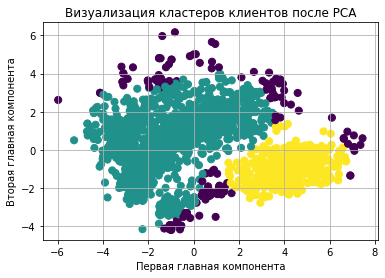

In [202]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_pred, cmap='viridis', s=50)

plt.title('Визуализация кластеров клиентов после PCA')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.grid(True)
plt.show()

# Анализ

<ipython-input-41-0263e2039846>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=y_pred, palette='viridis', legend=False)


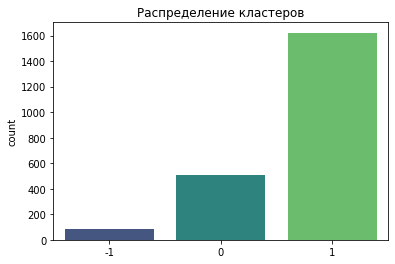

In [41]:
pl = sns.countplot(x=y_pred, palette='viridis', legend=False)
pl.set_title("Распределение кластеров")
plt.show()

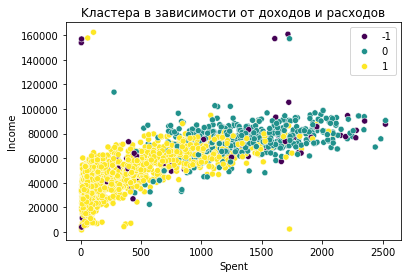

In [42]:
pl = sns.scatterplot(data=df, x=df["Spent"], y=df["Income"], hue=df["Clusters"], palette='viridis')
pl.set_title("Kластера в зависимости от доходов и расходов") 
plt.legend()
plt.show()

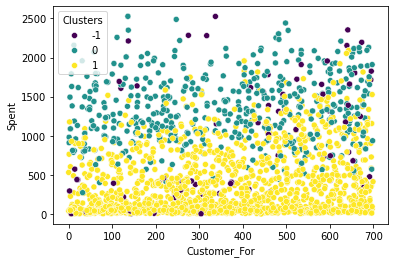

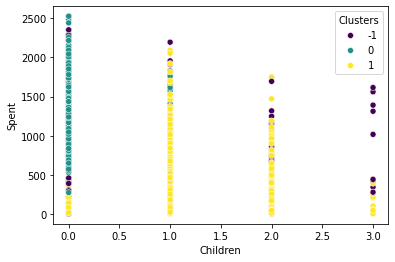

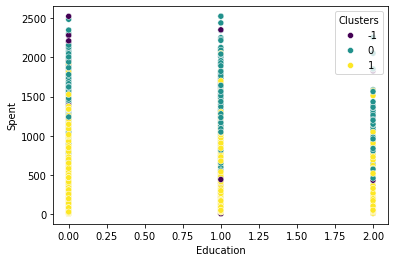

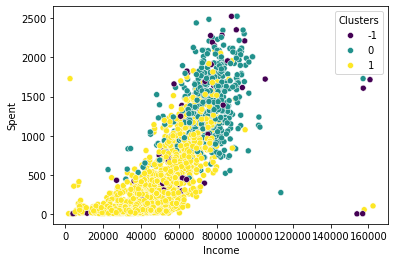

In [43]:
#TODO add names for eduaction
# TODO  порепетировать часть с графиками
Personal = [ "Customer_For", "Children", "Education", "Income"]

for i in Personal:
    plt.figure()
    sns.scatterplot(data=df, x=df[i], y=df["Spent"], hue=df["Clusters"], palette='viridis')
    plt.show()

**Заключение**


*Желтая*

 - В основном небольшие семьи от 1 до 2х человек.
 - Без детей.
 - высокий доход, высокие расходы.
 
*Cиняя*


 - Размер семьи: от 3 до 5 человек.
 - От одного ребенка
 - Средний доход, Средние расходы.


 
Cегменты клиентов и возможные маркетенговые стратегии:

**Желтая:** Люди без детей, высокий доход и расходы
- Персонализированные предложения: Скидки на товары премиум-класса и эксклюзивные товары, на основе предыдущих покупок

**Синяя** Семьи с одним и более детьми, низкий или умеренный  доход и умеренные расходы
- Семейные акции: Скидки на товары для дома и семейные наборы продуктов




Вспомним, что в занятии по k means у нас получилось 4 кластера, а DBSCAN мы видим что их 2. Почему так получилось? Дело в том, что в k-means параметр k - количество кластеров является обязательным гиперпараметром и алгоритм каждую точку обязательно отнесет к одному из k кластеров. При таком раскладе, алгоритм может создавать искуственные/несуществующие кластеры; в то время в DBSCAN сам определяет количество кластеров основываясь на том, как плотно точки расположены к друг другу.

# Кластеризаци с помощью метода HDBSCAN

In [47]:
hdbs = HDBSCAN()
y_pred_hdbs = hdbs.fit_predict(X_pca)
# Посчитаем силуэтный коэффициент и процент шума
clusters = len(np.unique(y_pred_hdbs))
score = silhouette_score(X_pca, y_pred_hdbs)
noise_ratio = sum(y_pred_hdbs == -1)/len(y_pred_hdbs)
print(f'HDBSCAN, Силуэтный коэффициент: {score}')
print(f'Уровень шума: {noise_ratio}')

HDBSCAN, Силуэтный коэффициент: -0.04577439980743686
Уровень шума: 0.34810126582278483


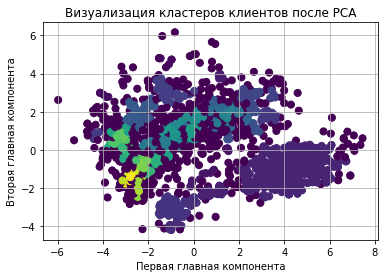

In [48]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_pred_hdbs, cmap='viridis', s=50)

plt.title('Визуализация кластеров клиентов после PCA')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.grid(True)
plt.show()

In [69]:
min_cluster_sizes = range(50, 300, 50)
min_samples_range = range(5, 50, 5)

best_silhouette = -1
best_params = {'min_cluster_size': None, 'min_samples': None}
results = []

for min_cluster_size in tqdm(min_cluster_sizes):
    for min_samples in min_samples_range:
        clusterer = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        labels = clusterer.fit_predict(X_pca)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if 1 < n_clusters < len(X_pca) - 1:
            sil_score = silhouette_score(X_pca, labels)
            results.append((min_cluster_size, min_samples, n_clusters, sil_score))
            
            if sil_score > best_silhouette:
                best_silhouette = sil_score
                best_params['min_cluster_size'] = min_cluster_size
                best_params['min_samples'] = min_samples

# Отсортируем результаты по силуэтному коэффициенту
results_sorted = sorted(results, key=lambda x: x[2:3], reverse=True)

for result in results_sorted:
    print(f"min_cluster_size: {result[0]}, min_samples: {result[1]}, n_clusters: {result[2]}, silhouette_score: {result[3]}")

100%|██████████| 5/5 [00:05<00:00,  1.09s/it]

min_cluster_size: 50, min_samples: 5, n_clusters: 3, silhouette_score: 0.26251344693816986
min_cluster_size: 50, min_samples: 10, n_clusters: 3, silhouette_score: 0.25781561186641816
min_cluster_size: 50, min_samples: 15, n_clusters: 3, silhouette_score: 0.23903394425915478
min_cluster_size: 50, min_samples: 20, n_clusters: 3, silhouette_score: 0.22705819778231928
min_cluster_size: 50, min_samples: 25, n_clusters: 3, silhouette_score: 0.19566980923051602
min_cluster_size: 50, min_samples: 30, n_clusters: 3, silhouette_score: 0.18586910636823648
min_cluster_size: 50, min_samples: 35, n_clusters: 3, silhouette_score: 0.18476421086427755
min_cluster_size: 50, min_samples: 40, n_clusters: 3, silhouette_score: 0.18108964528885083
min_cluster_size: 100, min_samples: 5, n_clusters: 3, silhouette_score: 0.26251344693816986
min_cluster_size: 100, min_samples: 10, n_clusters: 3, silhouette_score: 0.25781561186641816
min_cluster_size: 100, min_samples: 15, n_clusters: 3, silhouette_score: 0.23903

In [108]:
hdbs = HDBSCAN(min_cluster_size=50, min_samples=5)
y_pred_hdbs = hdbs.fit_predict(X_pca)
df['Clusters_hdbs'] = y_pred_hdbs

In [109]:
# Посчитаем силуэтный коэффициент и процент шума
clusters = len(np.unique(y_pred_hdbs))
score = silhouette_score(X_pca, y_pred_hdbs)
noise_ratio = sum(y_pred_hdbs == -1)/len(y_pred_hdbs)
print(f'HDBSCAN, Силуэтный коэффициент: {score}')
print(f'Уровень шума: {noise_ratio}')

HDBSCAN, Силуэтный коэффициент: 0.26251344693816986
Уровень шума: 0.07007233273056059


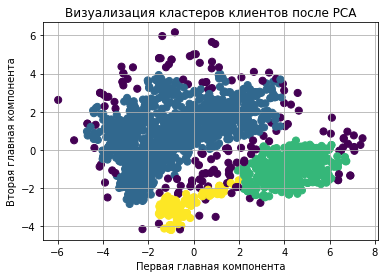

In [110]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_pred_hdbs, cmap='viridis', s=50)

plt.title('Визуализация кластеров клиентов после PCA')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.grid(True)
plt.show()

<ipython-input-111-a28326ff8967>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=y_pred_hdbs, palette='viridis')


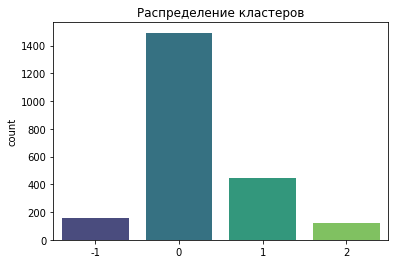

In [111]:
pl = sns.countplot(x=y_pred_hdbs, palette='viridis')
pl.set_title("Распределение кластеров")
plt.show()

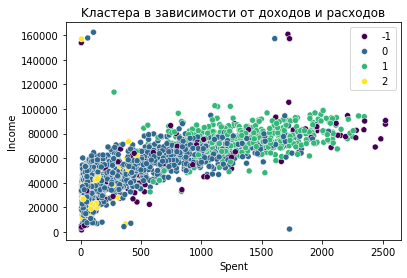

In [112]:
pl = sns.scatterplot(data=df, x=df["Spent"], y=df["Income"], hue=df["Clusters_hdbs"], palette='viridis')
pl.set_title("Kластера в зависимости от доходов и расходов") 
plt.legend()
plt.show()

In [113]:
import pandas as pd
spending_by_cluster = df.groupby("Clusters_hdbs")["Spent"].sum()
commodities = "Wines Fruits Meat Fish Sweets Gold".split()
avg_spending_by_commodity = df.groupby("Clusters_hdbs")[commodities].sum()
proportion = avg_spending_by_commodity.T / spending_by_cluster
proportion

Clusters_hdbs,-1,0,1,2
Wines,0.504890,0.571778,0.441185,0.363467
Fruits,0.044613,0.039107,0.046284,0.071040
Meat,0.259582,0.208139,0.343240,0.216518
Fish,0.073844,0.051368,0.068136,0.104891
Sweets,0.047472,0.039844,0.047336,0.078229
Gold,0.069599,0.089764,0.053819,0.165855


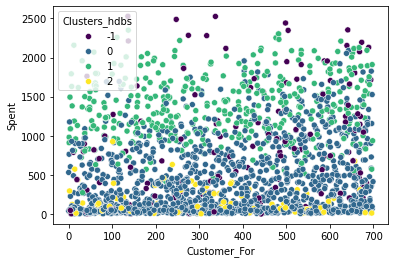

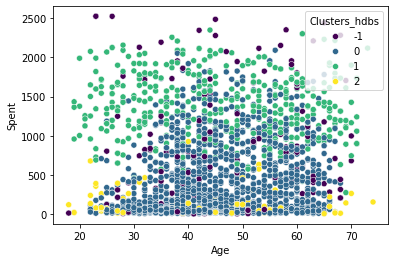

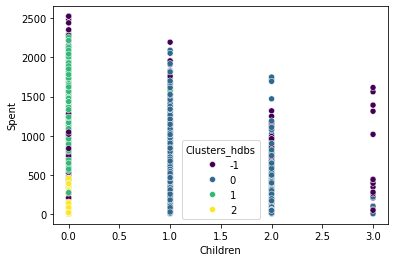

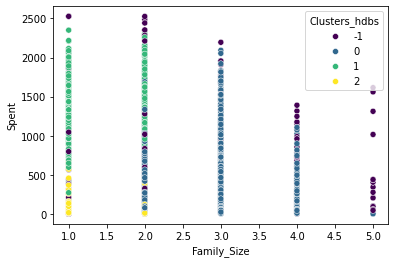

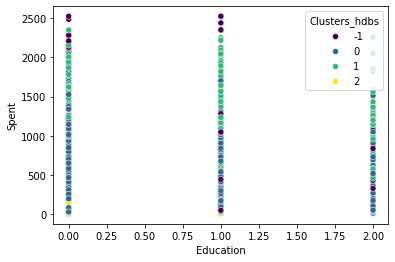

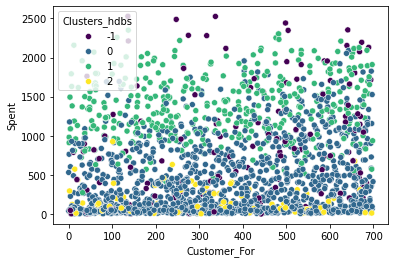

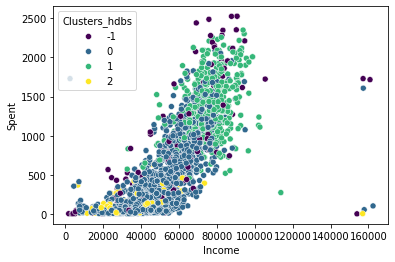

In [114]:
Personal = [ "Customer_For", "Age", "Children", "Family_Size","Education", "Customer_For", "Income"]

for i in Personal:
    plt.figure()
    sns.scatterplot(data=df, x=df[i], y=df["Spent"], hue=df["Clusters_hdbs"], palette='viridis')
    plt.show()

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2212 entries, 0 to 2239
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2212 non-null   int64  
 1   Education            2212 non-null   int64  
 2   Income               2212 non-null   float64
 3   Kidhome              2212 non-null   int64  
 4   Teenhome             2212 non-null   int64  
 5   Recency              2212 non-null   int64  
 6   Wines                2212 non-null   int64  
 7   Fruits               2212 non-null   int64  
 8   Meat                 2212 non-null   int64  
 9   Fish                 2212 non-null   int64  
 10  Sweets               2212 non-null   int64  
 11  Gold                 2212 non-null   int64  
 12  NumDealsPurchases    2212 non-null   int64  
 13  NumWebPurchases      2212 non-null   int64  
 14  NumCatalogPurchases  2212 non-null   int64  
 15  NumStorePurchases    2212 non-null   int64 

In [116]:
#TODO
#ADD interpretations

**Заключение**

*Желтая*

 - В основном одиночки.
 - Без детей.
 - Низкий доход, низкие расходы.

*Cиняя*


 - Размер семьи: от 3 до 5 человек.
 - От одного ребенка
 - Средний доход, Средние расходы.

*Зеленая*

 - В основном небольшие семьи от 1 до 2х человек.
 - Без детей.
 - высокий доход, высокие расходы.
 

 
    
Cегменты клиентов и возможные маркетенговые стратегии:
    
**Желтая** Одинокие люди, низкий или умеренный  доход и умеренные расходы
- Для одиноких людей с низким или умеренным доходом ритейлеры могут предложить маленькие упаковки продуктов, 
персонализированные скидки, готовые блюда, организовать социальные мероприятия и 
упростить процесс покупки через онлайн-заказы и экспресс-кассы.
    
**Синяя:** Люди без детей, высокий доход и расходы
- Персонализированные предложения: Скидки на товары премиум-класса и эксклюзивные товары, на основе предыдущих покупок

**Зеленая** Семьи с одним и более детьми, низкий или умеренный  доход и умеренные расходы
- Семейные акции: Скидки на товары для дома и семейные наборы продуктов


